In [1]:
import cmocean
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

import sys
sys.path.insert(0, '/home/561/jn8053/~/.local/lib')
from xarrayMannKendall import *

clnt = dsk.Client()
clnt

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/43573/status,
Dashboard: /proxy/43573/status,Workers: 4
Total threads: 16,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36665,Workers: 4
Dashboard: /proxy/43573/status,Total threads: 16
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:34171,Total threads: 4
Dashboard: /proxy/44107/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:36939,


In [2]:
keys = ['erai', 'era5', 'cfsr', 'jra55', 'reanalysis', 'cmip6']

In [3]:
mask = xr.open_dataset('../data/zero_div_line_with_wap_mask.nc')['__xarray_dataarray_variable__']
hu = xr.open_dataset('~/g_e14/misc/hu-01deg.nc')['hu'].sel(yu_ocean = slice(None, -50))
land_ice_mask = xr.where(np.isnan(hu.interp(yu_ocean = np.arange(-90, -50.1, .1))), 1, np.nan).interp(yu_ocean = np.arange(-90, -50.1, .1))
land_ice_mask = land_ice_mask.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
land_ice_mask['_lon_adj'] = xr.where(land_ice_mask['lon'] < -180, land_ice_mask['lon'] + 360, land_ice_mask['lon'])
land_ice_mask = land_ice_mask.swap_dims({'lon': '_lon_adj'})
land_ice_mask = land_ice_mask.sel(**{'_lon_adj': sorted(land_ice_mask._lon_adj)}).drop('lon')
land_ice_mask = land_ice_mask.rename({'_lon_adj': 'lon'})

# Divide line calculated as:
# cset = plt.contour(mask['lon'][1:], mask['lat'], xr.where(np.isnan(mask[:,1:]), 1, 0), levels = [0]); plt.close()
# div_lin = np.array([cset.allsegs[0][1][:,0], cset.allsegs[0][1][:,1]])
div_line = xr.open_dataset('../data/smooth_div_line.nc')['__xarray_dataarray_variable__']

In [5]:
uas_ssp85 = xr.open_dataset('../data/uas-monthly-2015_2100-cmip6ssp85.nc')['uas'].sel(time = slice('2015-01-01', '2100-01-01'))
vas_ssp85 = xr.open_dataset('../data/vas-monthly-2015_2100-cmip6ssp85.nc')['vas'].sel(time = slice('2015-01-01', '2100-01-01'))
psl_ssp85 = xr.open_dataset('../data/psl-monthly-2015_2100-cmip6ssp85.nc')['psl'].sel(time = slice('2015-01-01', '2100-01-01'))

In [6]:
u = uas_ssp85.groupby('time.year').mean('time')
MK_class = Mann_Kendall_test(u, 'time', coords_name = {'year':'time', 'lat':'y', 'lon':'x'})
uas_trends_ssp85 = MK_class.compute()
uas_trends_ssp85 = uas_trends_ssp85.rename({'x':'lon', 'y':'lat'})

v = vas_ssp85.groupby('time.year').mean('time')
MK_class = Mann_Kendall_test(v, 'time', coords_name = {'year':'time', 'lat':'y', 'lon':'x'})
vas_trends_ssp85 = MK_class.compute()
vas_trends_ssp85 = vas_trends_ssp85.rename({'x':'lon', 'y':'lat'})

In [7]:
psl_change_ssp85 = psl_ssp85.sel(time = slice('2090-01-01', '2100-01-01')).mean('time') - \
                   psl_ssp85.sel(time = slice('2015-01-01', '2025-01-01')).mean('time')

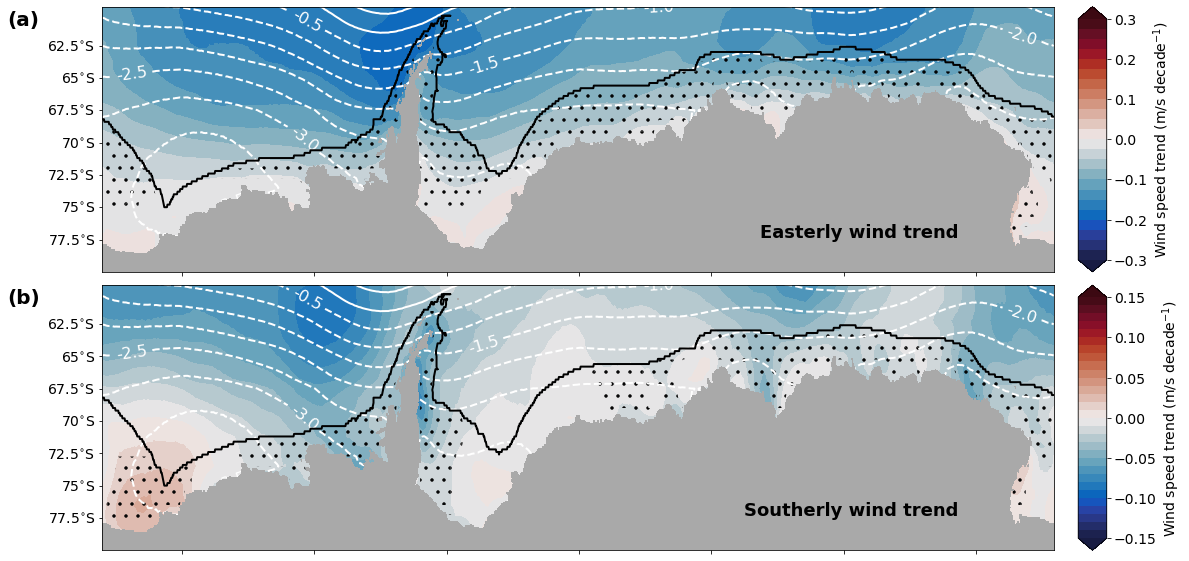

In [8]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (18, 10))
gr = gs.GridSpec(2, 2, figure = fig, width_ratios = [1, .03], 
                 hspace = .05, wspace = 0.05)
axs = [fig.add_subplot(gr[0,0]), fig.add_subplot(gr[1,0]),
       fig.add_subplot(gr[0,1]), fig.add_subplot(gr[1,1])]
for ax, label in zip(axs, ['(a)', '(b)']):
    ax.text(-0.1, .93, label, transform = ax.transAxes, size = 20, weight = 'bold')
    ax.set_xlim([-180, 179.25])
    ax.set_ylim([-80, -59.5])
    ax.set_yticks(np.arange(-77.5, -60, 2.5))
    ax.set_yticklabels(['77.5$^{\circ}$S', '75$^{\circ}$S', '72.5$^{\circ}$S', 
                        '70$^{\circ}$S', '67.5$^{\circ}$S', '65$^{\circ}$S', 
                        '62.5$^{\circ}$S'])
    if ax in [axs[0], axs[1]]:
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(-150, 200, 50))
        ax.set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', 
                            '0$^{\circ}$E',  '50$^{\circ}$E', '100$^{\circ}$E', 
                            '150$^{\circ}$E'])
    # Land
    ax.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, 
                colors = 'darkgrey', linewidths = 0.5, 
                zorder = 2)
    ax.plot(div_line[0], div_line[1], 'k', linewidth = 2, zorder = 2)

axs[0].text(0.9, .13, 'Easterly wind trend', horizontalalignment = 'right', transform = axs[0].transAxes, size = 18, weight = 'bold')
axs[1].text(0.9, .13, 'Southerly wind trend', horizontalalignment = 'right', transform = axs[1].transAxes, size = 18, weight = 'bold')

k = 'cmip6'
c = axs[0].contourf(uas_trends_ssp85['lon'], uas_trends_ssp85['lat'], -uas_trends_ssp85['trend']*10, 
                    levels = np.arange(-.3, .325, .025), extend = 'both', cmap = cmocean.cm.balance)
cbar = fig.colorbar(c, cax = axs[-2])
cbar.set_label('Wind speed trend (m/s decade$^{-1}$)')
cbar.set_ticks(np.arange(-.3, .4, .1))
axs[0].contourf(uas_trends_ssp85['lon'], uas_trends_ssp85['lat'], 
                xr.where(np.isnan(mask), np.nan, 1).interp(lat = vas[k]['lat'], lon = vas[k]['lon'])*uas_trends_ssp85['p'].where(uas_trends_ssp85['p'] <= .05),
                colors = ['none'], hatches = ['.'])
c = axs[0].contour(psl_change_ssp85['lon'], psl_change_ssp85['lat'], psl_change_ssp85/100,
                   levels = np.arange(-5, 5.5, .5), colors = ['white'], linewidths = [2], zorder = 1)
axs[0].clabel(c, c.levels, inline=True, fmt='%1.1f', fontsize=16, zorder = 1)

c = axs[1].contourf(vas_trends_ssp85['lon'], vas_trends_ssp85['lat'], vas_trends_ssp85['trend']*10, 
                    levels = np.arange(-.15, .16, .01), extend = 'both', cmap = cmocean.cm.balance)
cbar = fig.colorbar(c, cax = axs[-1])
cbar.set_label('Wind speed trend (m/s decade$^{-1}$)')
cbar.set_ticks(np.arange(-.15, .2, .05))
axs[1].contourf(vas_trends_ssp85['lon'], vas_trends_ssp85['lat'], 
                xr.where(np.isnan(mask), np.nan, 1).interp(lat = vas[k]['lat'], lon = vas[k]['lon'])*vas_trends_ssp85['p'].where(vas_trends_ssp85['p'] <= .05),
                colors = ['none'], hatches = ['.'])
c = axs[1].contour(psl_change_ssp85['lon'], psl_change_ssp85['lat'], psl_change_ssp85/100,
                   levels = np.arange(-5, 5.5, .5), colors = ['white'], linewidths = [2], zorder = 1)
axs[1].clabel(c, c.levels, inline=True, fmt='%1.1f', fontsize=16, zorder = 1)

plt.savefig('../results/v6/fig3.jpg', bbox_inches = 'tight', dpi = 800)